In [75]:
import torchvision
import torch
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from utils.dataset import ChestImage64
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split, DataLoader
from torch import optim

import torch.nn as nn
import time


In [76]:
csv_path = './Data/256px Images/train_labels_256p.csv'
root_path = './Data/256px Images'

In [77]:
transform = Compose([
    Resize((256, 256)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [125]:
dataset = ChestImage64(csv_path=csv_path, root_path=root_path, class_name="Frontal", transform=transform)

In [131]:
train_size = round(0.8 * len(dataset))
val_size = round(0.1 * len(dataset))
test_size = round(0.1 * len(dataset))


In [127]:
train_size + val_size + test_size

30630

In [128]:
len(dataset)

30630

In [132]:

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset,batch_size=32, shuffle=True)

In [70]:
import pandas as pd
df = pd.read_csv(csv_path)
df.columns.tolist()
columns = ['Image_Path',
 'Patient',
 'Study',
 'Frontal/Lateral',
 'Enlarged Cardiomediastinum',
 'Cardiomegaly',
 'Lung Opacity',
 'Lung Lesion',
 'Edema',
 'Consolidation',
 'Pneumonia',
 'Atelectasis',
 'Pneumothorax',
 'Pleural Effusion',
 'Pleural Other',
 'Fracture',
 'Support Devices',
 'No Finding']
df.columns = columns
df.to_csv(csv_path, index=False)

In [62]:
import pandas as pd
df = pd.read_csv(csv_path)
df.columns.tolist()

['Image_Path',
 'Patient',
 'Study',
 'Frontal/Lateral',
 'Enlarged Cardiomediastinum',
 'Cardiomegaly',
 'Lung Opacity',
 'Lung Lesion',
 'Edema',
 'Consolidation',
 'Pneumonia',
 'Atelectasis',
 'Pneumothorax',
 'Pleural Effusion',
 'Pleural Other',
 'Fracture',
 'Support Devices',
 'No Finding']

In [63]:
import pandas as pd

def replace_backslash_in_column(file_path, column_name):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)

    # Replace the backslash in the data of the specific column
    df[column_name] = df[column_name].str.replace(r'\\', "/")

    # Save the modified DataFrame back to the CSV file
    df.to_csv(file_path, index=False)

file_path = '/path/to/your/csv_file.csv'

# Define the column name in which you want to replace the backslash
column_name = 'your_column_name'

# Call the function to replace the backslash in the data of the specific column
replace_backslash_in_column(csv_path, "Image_Path")

/mnt/bgfs/zare/4451249/ipykernel_4030654/712429384.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column_name] = df[column_name].str.replace(r'\\', "/")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


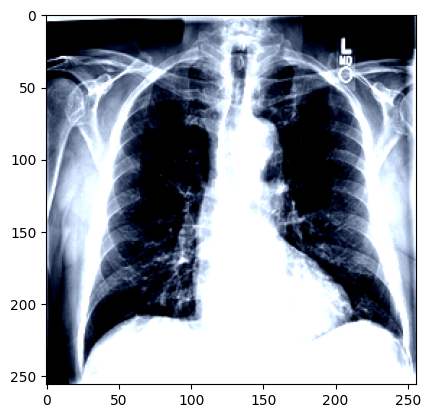

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1.])


In [133]:
for item in train_loader:
    image = item[0][0].numpy()/2 + 0.5
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.show()
    print(item[1][0])
    break
    

In [134]:
model = torchvision.models.resnet152(pretrained=True)
num_classes = 14
for param in model.parameters():
    param.requires_grad = True

model.fc = nn.Sequential(
            nn.Linear(model.fc.in_features, num_classes)
        )
for param in model.fc.parameters():
    param.requires_grad = True

/home/zare/.conda/envs/quantize/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zare/.conda/envs/quantize/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [55]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [135]:
## define the data

optimizer = optim.Adam(model.parameters(), lr=1e-3)

sum(p.numel() for p in model.parameters())

criterion = torch.nn.BCEWithLogitsLoss()

def train_epoch(model, optimizer, data_loader, loss_history, device):
    total_samples = len(data_loader.dataset)
    model.train()

    for i, (data, target) in enumerate(data_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output,target)

        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print('[' + '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(data_loader)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(loss.item()))
            loss_history.append(loss.item())


# %%
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:2' if use_cuda else 'cpu')

N_EPOCHS = 7

start_time = time.time()

model.to(device)

train_loss_history, test_loss_history = [], []
for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch)
    train_epoch(model, optimizer, train_loader, train_loss_history, device)
    # evaluate(model, test_loader, test_loss_history, device)

Epoch: 1
[    0/24504 (  0%)]  Loss: 0.7053
[ 3200/24504 ( 13%)]  Loss: 0.3763
[ 6400/24504 ( 26%)]  Loss: 0.5350
[ 9600/24504 ( 39%)]  Loss: 0.4427
[12800/24504 ( 52%)]  Loss: 0.4605
[16000/24504 ( 65%)]  Loss: 0.4412
[19200/24504 ( 78%)]  Loss: 0.3553
[22400/24504 ( 91%)]  Loss: 0.3959
Epoch: 2
[    0/24504 (  0%)]  Loss: 0.3508
[ 3200/24504 ( 13%)]  Loss: 0.3777
[ 6400/24504 ( 26%)]  Loss: 0.3756
[ 9600/24504 ( 39%)]  Loss: 0.3964
[12800/24504 ( 52%)]  Loss: 0.3471
[16000/24504 ( 65%)]  Loss: 0.3669
[19200/24504 ( 78%)]  Loss: 0.2935
[22400/24504 ( 91%)]  Loss: 0.3520
Epoch: 3
[    0/24504 (  0%)]  Loss: 0.3335
[ 3200/24504 ( 13%)]  Loss: 0.4158
[ 6400/24504 ( 26%)]  Loss: 0.4067
[ 9600/24504 ( 39%)]  Loss: 0.3596
[12800/24504 ( 52%)]  Loss: 0.3242
[16000/24504 ( 65%)]  Loss: 0.3398
[19200/24504 ( 78%)]  Loss: 0.4028
[22400/24504 ( 91%)]  Loss: 0.4071
Epoch: 4
[    0/24504 (  0%)]  Loss: 0.4182
[ 3200/24504 ( 13%)]  Loss: 0.3965
[ 6400/24504 ( 26%)]  Loss: 0.3762
[ 9600/24504 ( 39%)

In [114]:
def multi_class_multi_label_accuracy(y_pred, y_true, threshold=0.5):
    # Apply sigmoid function to raw outputs
    y_pred = torch.sigmoid(y_pred)

    # Threshold the predictions
    y_pred = (y_pred > threshold).float()
    # Compute accuracy
    correct = (y_pred == y_true).float()
    accuracy = correct.sum() / (y_true.numel())

    return accuracy


In [115]:
device

device(type='cuda', index=2)

In [119]:
# Import torch and the accuracy function
import torch
total_accuracy  = []
for test_data, target in test_loader:
    # Compute multi-class multi-label accuracy
    test_data = test_data.to(device)
    target = target.to(device)
    model.to(device)
    y_pred = model(test_data)
    accuracy = multi_class_multi_label_accuracy(y_pred, target, threshold=0.5)
    total_accuracy.append(accuracy.item())

print("Accuracy: {:.2f}".format((np.mean(total_accuracy))))


Accuracy: 0.83


In [24]:
total_accuracy

[0.8147321343421936,
 0.7477678656578064,
 0.7723214030265808,
 0.7098214030265808,
 0.6785714030265808,
 0.7410714030265808,
 0.7544642686843872,
 0.78125,
 0.796875,
 0.7991071343421936,
 0.7455357313156128,
 0.7165178656578064,
 0.7946428656578064,
 0.7857142686843872,
 0.7991071343421936,
 0.765625,
 0.7901785969734192,
 0.8169642686843872,
 0.7700892686843872,
 0.7120535969734192,
 0.7433035969734192,
 0.7522321343421936,
 0.7120535969734192,
 0.7120535969734192,
 0.78125,
 0.6986607313156128,
 0.7366071343421936,
 0.6941964030265808,
 0.7455357313156128,
 0.7544642686843872,
 0.7745535969734192,
 0.7321428656578064,
 0.7455357313156128,
 0.7477678656578064,
 0.75,
 0.7276785969734192,
 0.7566964030265808,
 0.7879464030265808,
 0.7767857313156128,
 0.7299107313156128,
 0.7790178656578064,
 0.7388392686843872,
 0.78125,
 0.7321428656578064,
 0.7165178656578064,
 0.7522321343421936,
 0.7388392686843872,
 0.7834821343421936,
 0.7767857313156128,
 0.7901785969734192,
 0.78348213434219

In [162]:
for item in train_loader:
    X = item[0][0:32]
    Y = item[1][0:32]
    break

In [163]:
Y

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0.],
        [1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0.],
        [1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0.],
        [1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
        [0

In [164]:
N = 15
n = 32
lambdas = torch.linspace(0,1,N) # N can be taken to infinity without penalty
losses = torch.zeros((n,N)) # loss for example i with parameter lambdas[j]
model.to('cpu')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [165]:
alpha, delta = 0.3 , 0.2
for i in range(n): # In reality we parallelize these loops massively
    sigmoids = model(X[i].unsqueeze(0)).sigmoid().squeeze() # Care with dims
    for j in range(N):
        T = sigmoids > lambdas[j] # This is the prediction set
        set_size = T.float().sum()
        if set_size != 0:
            true_label = Y[i].nonzero(as_tuple=True)[0]
            losses[i,j] = 1 - (T[true_label] == True).float().sum()/set_size



In [136]:
risk = losses.mean(dim=0)
pvals = torch.exp(-2*n*(torch.relu(alpha-risk)**2)) # Or the HB p-value
# Fixed-sequence test starting at lambdas[-1] and ending at lambdas[0]
below_delta = (pvals <= delta).float()
valid = torch.tensor([(below_delta[j:].mean() == 1) for j in range(N)])
lambda_hat = lambdas[valid]

In [137]:
lambda_hat

tensor([0.2857, 0.3571, 0.4286, 0.5000, 0.5714, 0.6429, 0.7143, 0.7857, 0.8571,
        0.9286, 1.0000])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


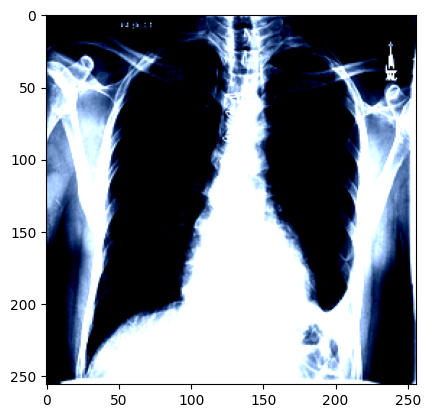

tensor([1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0.])


In [141]:
for item in train_loader:
    image = item[0][0]
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.show()
    print(item[1][0])
    break
    

In [147]:
image = image.to(device)
output = model(image.unsqueeze(0)).sigmoid()

In [167]:
[ 1 if item>=0.2857 else 0 for item in output[0]]

[1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0]

In [149]:
[ x if x%2 else x*100 for x in range(1, 10) ]


[1, 200, 3, 400, 5, 600, 7, 800, 9]

In [157]:
for item in output:
    print (item)

ValueError: only one element tensors can be converted to Python scalars

In [159]:
output[0]

tensor([0.5361, 0.3456, 0.6382, 0.0507, 0.0672, 0.2801, 0.2115, 0.4615, 0.0533,
        0.3686, 0.1667, 0.4551, 0.3913, 0.0393], device='cuda:2',
       grad_fn=<SelectBackward0>)

In [168]:
import torch

# Define your model and load the state_dict if needed
# model.load_state_dict(torch.load("path/to/your/model_weights.pth"))

# Move the model to the appropriate device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Set the model to evaluation mode
model.eval()

# Initialize a tensor to store the class-wise correct predictions and total predictions
num_classes = 14  # Set the number of classes in your problem
class_correct = torch.zeros(num_classes, device=device)
class_total = torch.zeros(num_classes, device=device)

# Iterate over the test dataset using the test_loader
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Apply sigmoid function to raw outputs
        y_pred = torch.sigmoid(outputs)

        # Threshold the predictions
        y_pred = (y_pred > 0.5).float()

        # Compute class-wise correct predictions and total predictions
        correct = (y_pred == labels).float()
        class_correct += correct.sum(dim=0)
        class_total += labels.size(0)
        
# Calculate the class-wise accuracies
class_accuracies = class_correct / class_total

# Print the class-wise accuracies
for i, class_accuracy in enumerate(class_accuracies):
    print(f"Accuracy for class {i}: {class_accuracy:.2f}")

# Calculate the average accuracy across all classes
average_accuracy = class_accuracies.mean()
print(f"Average accuracy: {average_accuracy:.2f}")


Accuracy for class 0: 0.82
Accuracy for class 1: 0.83
Accuracy for class 2: 0.85
Accuracy for class 3: 0.91
Accuracy for class 4: 0.85
Accuracy for class 5: 0.85
Accuracy for class 6: 0.84
Accuracy for class 7: 0.86
Accuracy for class 8: 0.92
Accuracy for class 9: 0.87
Accuracy for class 10: 0.81
Accuracy for class 11: 0.78
Accuracy for class 12: 0.82
Accuracy for class 13: 0.85
Average accuracy: 0.85


In [169]:
for i, class_accuracy in enumerate(class_accuracies):
    print(f"{class_accuracy:.2f}")


0.82
0.83
0.85
0.91
0.85
0.85
0.84
0.86
0.92
0.87
0.81
0.78
0.82
0.85
